# LSTM을 이용하여 외부 환경 데이터로 온실 내부 환경 예측하기

- 전북대학교 원예학과 실험 온실에서 수집한 온실 내부 데이터와 기상청 ASOS에서 수집한 외부 환경 데이터를 이용함.

- 수집한 데이터는 1시간 단위 데이터임.

- 2023년 5월 10일 부터 2024년 3월 19일 까지의 데이터로 학습하고, 2024년 3월 20일 부터 27일 까지의 데이터를 테스트 데이터로 사용하여 평가함.

- Window Size는 12로 설정하고 pred Window Size는 12로 설정함. 이는 지난 12시간 외부환경을 가지고 다음 12 시간의 온실 내부 환경을 예측해나감을 의미함. 각 timestep 마다 예측 결과를 도출할 수 있음.

- 날짜는 학습에 사용하지 않았음.

## 학습 및 테스트 데이터 선언

In [43]:
import pandas as pd

# 데이터 로드 및 전처리
df = pd.read_csv('/content/preprocessed_data.csv')
test_df = pd.read_csv('/content/test_data.csv')

df

,Date&Time,inner_temp,inner_hum,inner_CO2,inner_PPF,out_radn_m,out_temp,out_wind,out_hum,out_radn_w
0,2023-05-10 17:00,27.6,37,407,407,1.74,23.1,3.4,47,483.3372
1,2023-05-10 18:00,26.2,36,407,101,0.96,21.5,2.9,44,266.6688
2,2023-05-10 19:00,22.3,40,415,6,0.29,19.6,1.0,43,80.5562
3,2023-05-10 20:00,18.9,53,425,0,0.01,18.2,2.0,46,2.7778
4,2023-05-10 21:00,17.5,56,412,0,0.00,17.2,2.7,54,0.0000
...,...,...,...,...,...,...,...,...,...,...
7486,2024-03-19 19:00,10.3,62,419,0,0.04,6.3,5.6,65,11.1112
7487,2024-03-19 20:00,9.4,65,420,0,0.00,6.0,4.9,62,0.0000
7488,2024-03-19 21:00,8.9,66,419,0,0.00,5.5,3.9,64,0.0000
7489,2024-03-19 22:00,8.3,65,418,0,0.00,5.0,4.1,62,0.0000


## 모델 학습

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


373/373 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0406 - val_loss: 0.0121
Epoch 2/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 3/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 4/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 5/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 6/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 7/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 8/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 9/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 10/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 11/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 12/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 11s 1

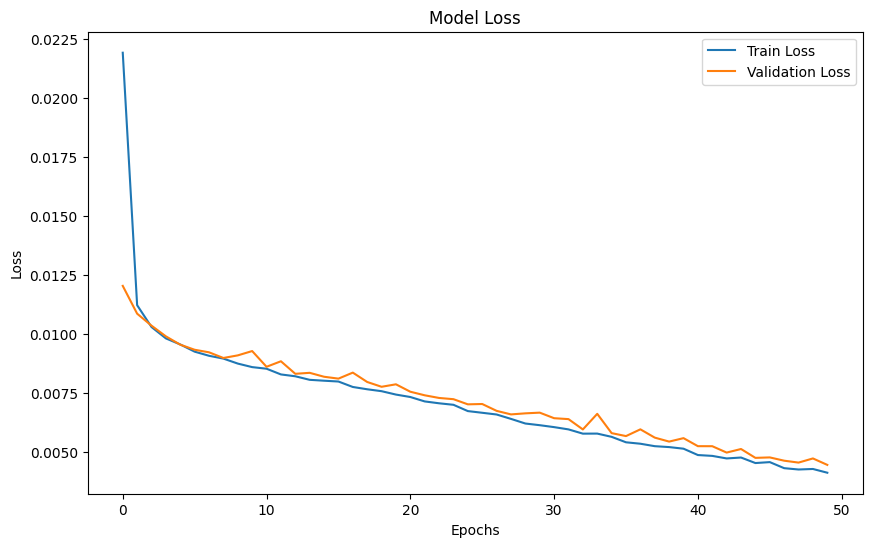

In [44]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
import joblib
import matplotlib.pyplot as plt

# 데이터 컬럼 선택
out_columns = [col for col in df.columns if 'out' in col]
inner_columns = [col for col in df.columns if 'inner' in col]

X = df[out_columns].values
y = df[inner_columns].values

# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 스케일러 저장
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# 윈도우 데이터 생성 함수 (이제 y를 다음 12시간 동안의 데이터로 설정)
def create_windowed_data(X, y, window_size, pred_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size - pred_size + 1):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size:i+window_size+pred_size])
    return np.array(Xs), np.array(ys)

window_size = 24
pred_size = 12
X_windowed, y_windowed = create_windowed_data(X_scaled, y_scaled, window_size, pred_size)
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

# LSTM 모델 정의 (마지막 레이어의 뉴런 수를 pred_size로 설정)
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(pred_size * y_train.shape[2]))
model.add(Reshape((pred_size, y_train.shape[2])))

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
model.save('lstm_model.h5')

# loss 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 학습 결과 시각화

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


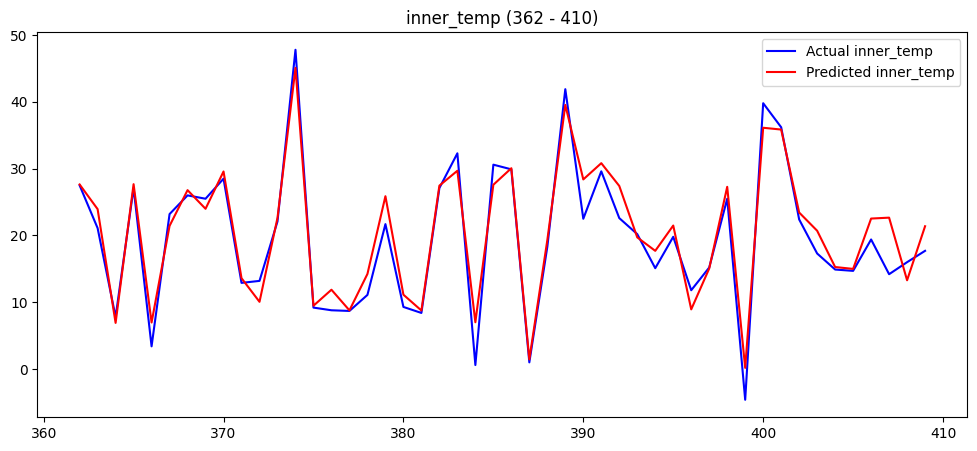

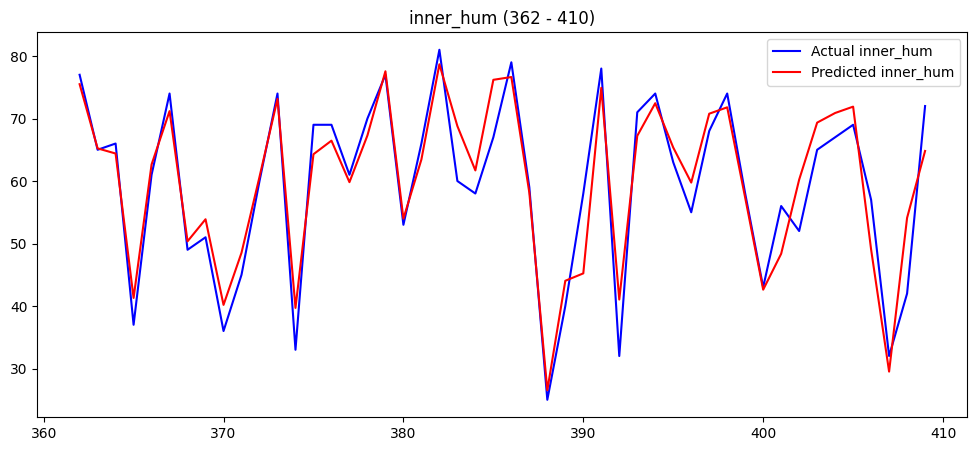

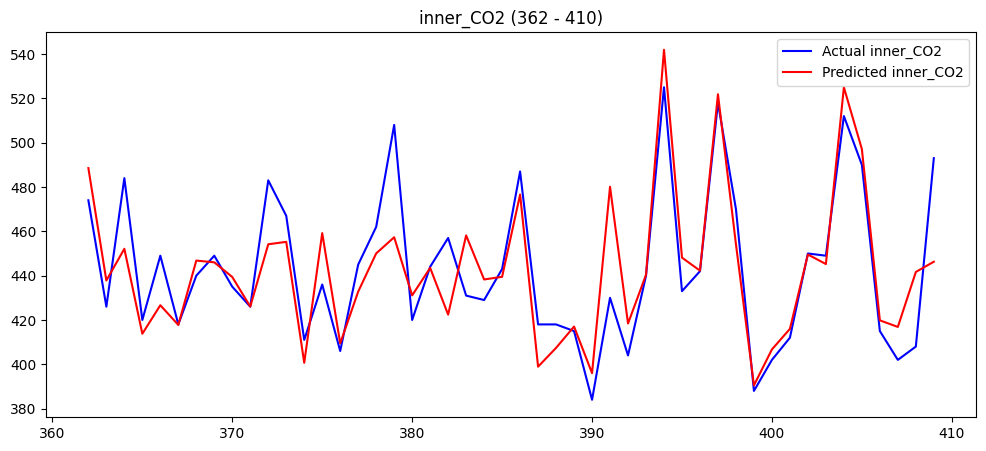

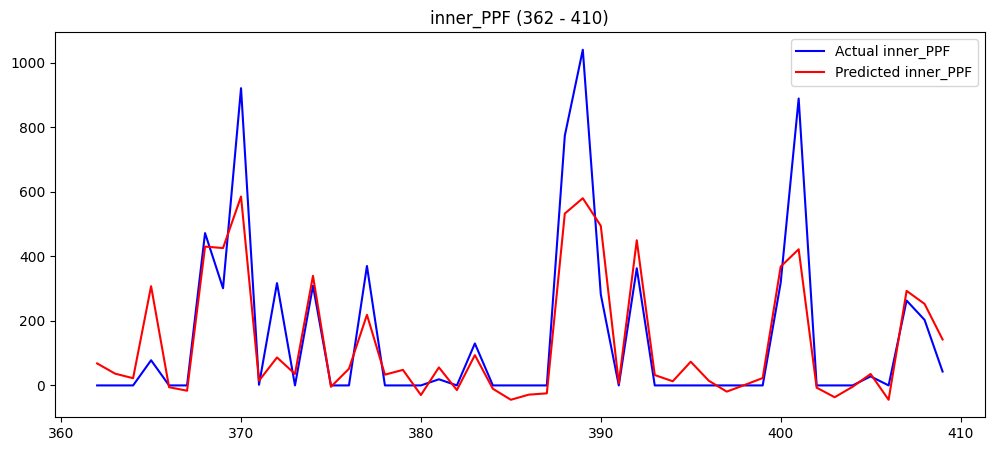

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled[:, -1, :])  # 마지막 타임스텝
y_test_actual_unscaled = scaler_y.inverse_transform(y_test[:, -1, :])  # 마지막 타임스텝

# 랜덤 샘플 추출 후 시각화
def plot_random_sample(y_test_actual, y_pred, inner_columns, sample_size):
    num_samples = y_test_actual.shape[0]
    start_index = np.random.randint(0, num_samples - sample_size)
    end_index = start_index + sample_size

    for i, column in enumerate(inner_columns):
        plt.figure(figsize=(12, 5))
        sns.lineplot(x=np.arange(start_index, end_index),
                     y=y_test_actual[start_index:end_index, i],
                     label=f'Actual {column}', color='blue')
        sns.lineplot(x=np.arange(start_index, end_index),
                     y=y_pred[start_index:end_index, i],
                     label=f'Predicted {column}', color='red')
        plt.title(f'{column} ({start_index} - {end_index})')
        plt.legend()
        plt.show()

plot_random_sample(y_test_actual_unscaled, y_pred, inner_columns, sample_size=48)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


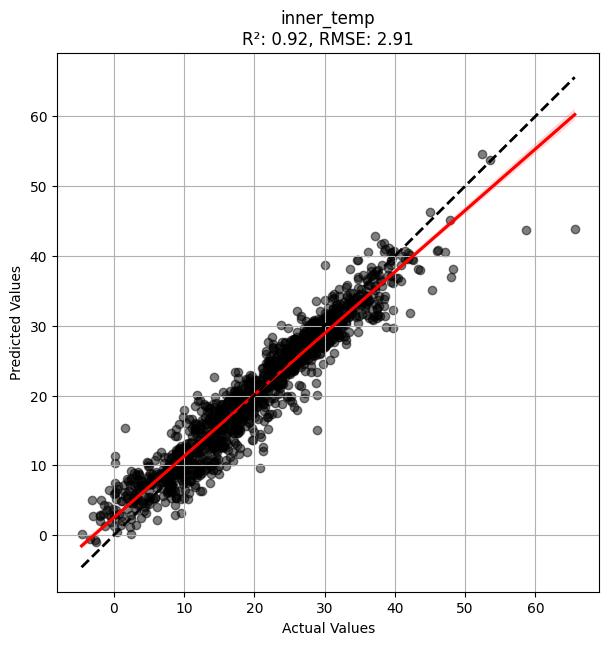

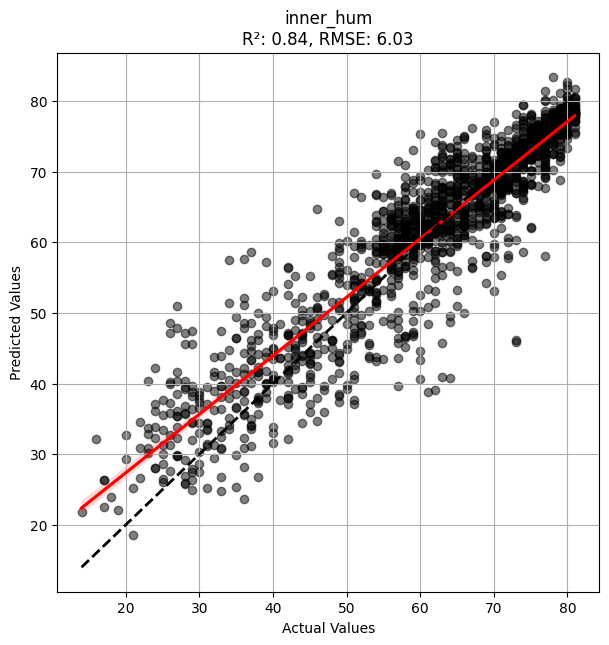

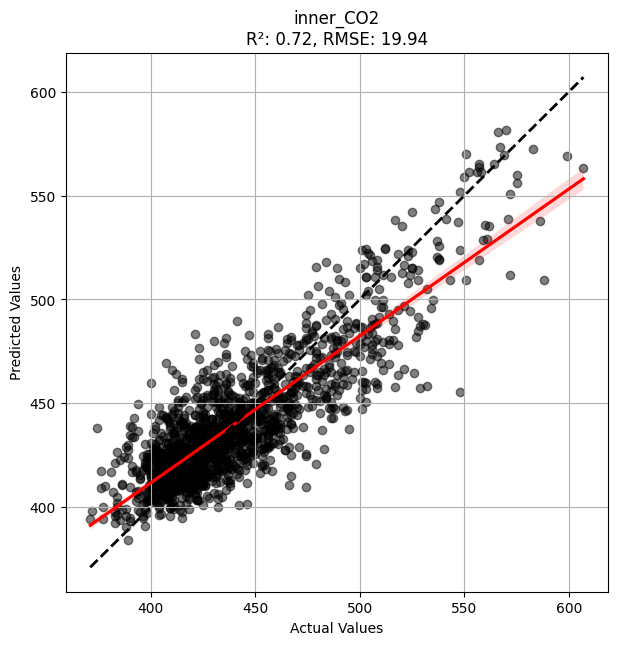

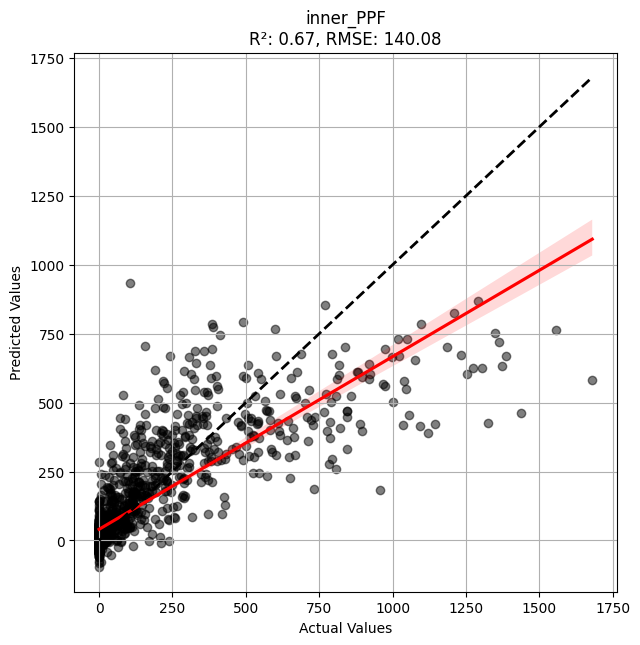

In [46]:
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled[:, -1, :])  # 마지막 타임스텝
y_test_actual_unscaled = scaler_y.inverse_transform(y_test[:, -1, :])  # 마지막 타임스텝

def plot_full_test_with_metrics(y_test_actual, y_pred, inner_columns, alpha=0.5):
    for i, column in enumerate(inner_columns):
        actual = y_test_actual[:, i]
        predicted = y_pred[:, i]

        r2 = r2_score(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        plt.figure(figsize=(7, 7))
        sns.regplot(x=actual, y=predicted, scatter_kws={'alpha': alpha, 'color': 'black'}, line_kws={'color': 'red'})
        plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
        plt.title(f'{column}\nR²: {r2:.2f}, RMSE: {rmse:.2f}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True)
        plt.show()

plot_full_test_with_metrics(y_test_actual_unscaled, y_pred, inner_columns)


## 테스트 데이터를 이용한 모델 검증

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


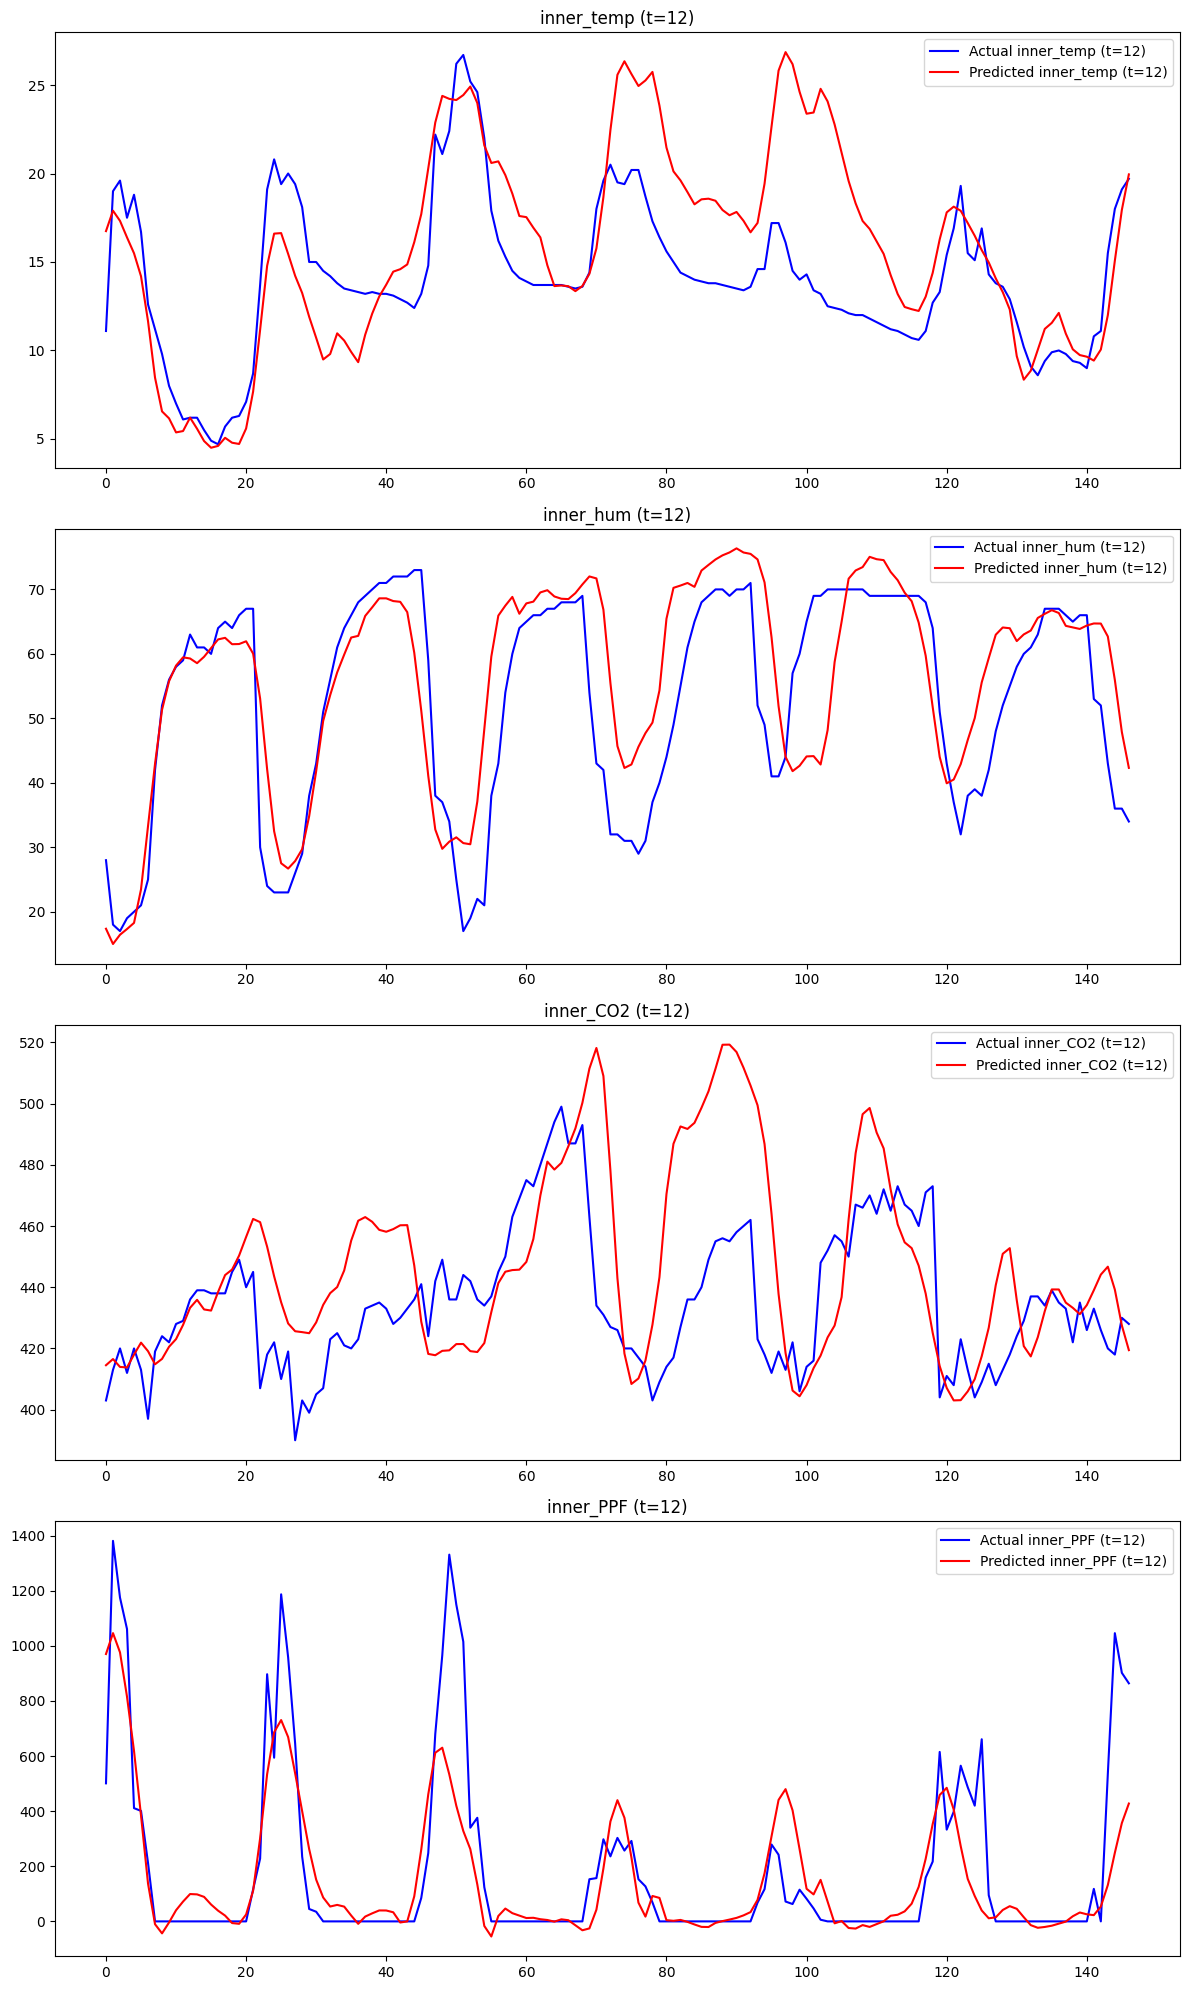

In [47]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

model = load_model('/content/lstm_model.h5')
scaler_X = joblib.load('/content/scaler_X.pkl')
scaler_y = joblib.load('/content/scaler_y.pkl')

out_columns = [col for col in test_df.columns if 'out' in col]
inner_columns = [col for col in test_df.columns if 'inner' in col]

X_test_new = test_df[out_columns].values
y_test_actual = test_df[inner_columns].values

X_test_new_scaled = scaler_X.transform(X_test_new)
y_test_actual_scaled = scaler_y.transform(y_test_actual)

window_size = 24
pred_size = 12

X_test_windowed, y_test_windowed = create_windowed_data(X_test_new_scaled, y_test_actual_scaled, window_size, pred_size)

# 예측 수행
y_pred_scaled = model.predict(X_test_windowed)
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, y_pred_scaled.shape[-1]))

# 실제 테스트 데이터 스케일링 역변환
y_test_actual_unscaled = scaler_y.inverse_transform(y_test_windowed.reshape(-1, y_test_windowed.shape[-1]))
num_time_steps = y_test_windowed.shape[1]
num_inner_columns = y_test_windowed.shape[2]
last_time_step = num_time_steps - 1

# 시각화
plt.figure(figsize=(12, 5 * num_inner_columns))
for i in range(num_inner_columns):
    plt.subplot(num_inner_columns, 1, i + 1)
    sns.lineplot(data=y_test_actual_unscaled[last_time_step::num_time_steps, i], label=f'Actual {inner_columns[i]} (t={last_time_step+1})', color='blue')
    sns.lineplot(data=y_pred_unscaled[last_time_step::num_time_steps, i], label=f'Predicted {inner_columns[i]} (t={last_time_step+1})', color='red')
    plt.title(f'{inner_columns[i]} (t={last_time_step+1})')
    plt.legend()

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


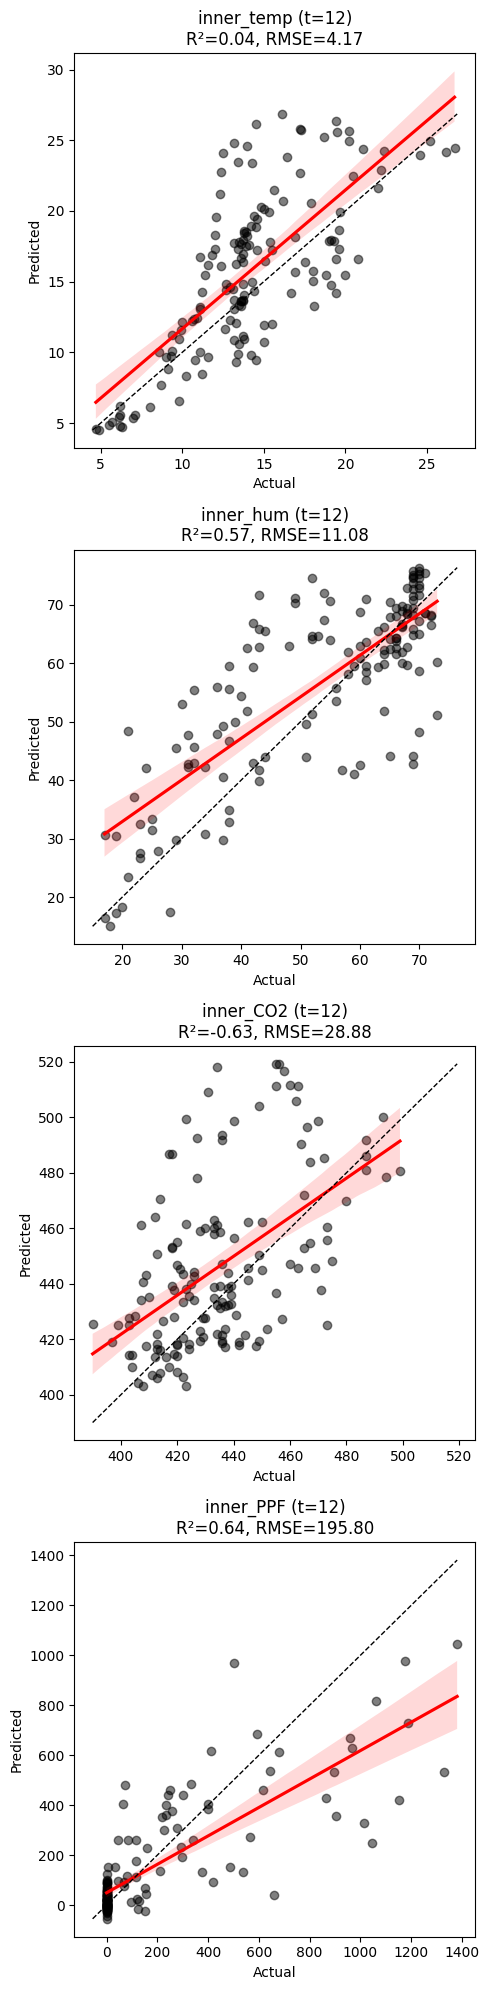

In [48]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# 모델 및 스케일러 로드
model = load_model('/content/lstm_model.h5')
scaler_X = joblib.load('/content/scaler_X.pkl')
scaler_y = joblib.load('/content/scaler_y.pkl')

# 테스트 데이터에서 필요한 컬럼 선택
out_columns = [col for col in test_df.columns if 'out' in col]
inner_columns = [col for col in test_df.columns if 'inner' in col]

X_test_new = test_df[out_columns].values
y_test_actual = test_df[inner_columns].values

X_test_new_scaled = scaler_X.transform(X_test_new)
y_test_actual_scaled = scaler_y.transform(y_test_actual)

# Window 사이즈 및 Pred 사이즈
window_size = 24
pred_size = 12
X_test_windowed, y_test_windowed = create_windowed_data(X_test_new_scaled, y_test_actual_scaled, window_size, pred_size)

# 예측
y_pred_scaled = model.predict(X_test_windowed)
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, y_pred_scaled.shape[-1]))
y_test_actual_unscaled = scaler_y.inverse_transform(y_test_windowed.reshape(-1, y_test_windowed.shape[-1]))

last_time_step = y_test_windowed.shape[1] - 1
num_inner_columns = y_test_windowed.shape[2]

# 시각
plt.figure(figsize=(5, 5 * num_inner_columns))
for i in range(num_inner_columns):
    plt.subplot(num_inner_columns, 1, i + 1)

    actual = y_test_actual_unscaled[last_time_step::num_time_steps, i]
    predicted = y_pred_unscaled[last_time_step::num_time_steps, i]

    r2 = r2_score(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    sns.regplot(x=actual, y=predicted, scatter_kws={'color': 'black', 'alpha': 0.5}, line_kws={'color': 'red'})
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

    plt.title(f'{inner_columns[i]} (t={last_time_step+1})\nR²={r2:.2f}, RMSE={rmse:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.show()
